In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam as adam
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import glob
import numpy as np
from pathlib import Path
from itertools import product as myzip

In [2]:
my_path = 'D:\s4353631\keras_png_slices_data\keras_png_slices_'
datasets = ['train', 'validate', 'test']
pixels = [0, 85, 170, 255]
data_dict = {}

In [3]:
def format_fn(path):
    img = tf.io.read_file(path)
    tens = tf.image.decode_png(img)
    
    return tf.reshape(tens, [256, 256, 1])

def path_2_tens(x_path, y_path):
    x = format_fn(x_path)
    x = tf.cast(x, tf.float32)/127.5 - 1.0
    
    y = format_fn(y_path)
    y = tf.reshape(y, [256, 256])
    y = tf.stack([y==pixel for pixel in pixels], axis=2)
    y = tf.cast(y, tf.float32)
    
    return x, y

In [4]:
for dataset in datasets:
    x_paths = glob.glob(my_path + dataset + '\*.png')
    y_paths = glob.glob(my_path + 'seg_' + dataset + '\*.png')
    data_dict[dataset] = tf.data.Dataset.from_tensor_slices((x_paths, y_paths))
    data_dict[dataset] = data_dict[dataset].map(path_2_tens)

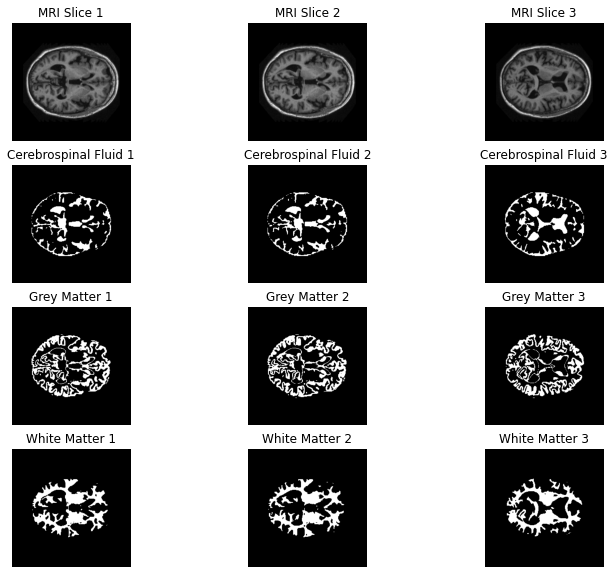

In [5]:
x_sample, y_sample = next(iter(data_dict['train'].batch(3)))
x_sample = tf.reshape(x_sample, [3, 256, 256])
y_sample = tf.reshape(y_sample, [3, 256, 256, 4])

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12, 10))
labels = ['Cerebrospinal Fluid ', 'Grey Matter ', 'White Matter ']

for i, j in myzip(range(3), range(1, 4)):
    ax[0][i].imshow(x_sample[i], cmap='gray')
    ax[0][i].axis('off')
    ax[0][i].set_title('MRI Slice ' + str(i+1))
    
    ax[j][i].imshow(y_sample[i, :, :, j], cmap='gray')
    ax[j][i].axis('off')
    ax[j][i].set_title(labels[j-1] + str(i+1))
    
plt.show()

In [73]:
# class Downshift(tf.keras.layers.Layer):
#     def __init__(self, filters, kernel_size=(3, 3)):
#         super(Downshift, self).__init__()
#         self.conv2d_1 = tf.keras.layers.Conv2D(filters=filters, \
#            kernel_size=kernel_size, activation='relu', padding='same')
#         self.conv2d_2 = tf.keras.layers.Conv2D(filters=filters, \
#            kernel_size=kernel_size, activation='relu', padding='same')
#         self.maxpool_1 = tf.keras.layers.MaxPooling2D(padding='same')
        
#     def call(self, x_0):
#         x_1 = self.conv2d_1(x_0)
#         x_2 = self.conv2d_2(x_1)
#         x_3 = self.maxpool_1(x_2)
        
#         return x_3
    
# class Upshift(tf.keras.layers.Layer):
#     def __init__(self, filters, kernel_size=(3, 3)):
#         super(Upshift, self).__init__()
#         self.upsampling_1 = tf.keras.layers.UpSampling2D()
#         self.conv2d_1 = tf.keras.layers.Conv2D(filters=filters, \
#            kernel_size=kernel_size, activation='relu', padding='same')
#         self.concatenate_1 = tf.keras.layers.Concatenate()
#         self.conv2d_2 = tf.keras.layers.Conv2D(filters=filters, \
#            kernel_size=kernel_size, activation='relu', padding='same')
#         self.conv2d_3 = tf.keras.layers.Conv2D(filters=filters, \
#            kernel_size=kernel_size, activation='relu', padding='same')
        
#     def call(self, x_0, concatenate):
#         x_1 = self.upsampling_1(x_0)
#         x_2 = self.conv2d_1(x_1)
#         x_3 = self.concatenate_1([concatenate, x_2])
#         x_4 = self.conv2d_2(x_3)
#         x_5 = self.conv2d_3(x_4)
        
#         return x

class Downshift(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(Downshift, self).__init__()
        self.conv2d_1 = tf.keras.layers.Conv2D(filters, 3, activation='relu', padding='same')
        self.conv2d_2 = tf.keras.layers.Conv2D(filters, 3, activation='relu', padding='same')
        self.maxpool_1 = tf.keras.layers.MaxPooling2D(padding='same')
        
    def call(self, x_0):
        x_1 = self.conv2d_1(x_0)
        x_2 = self.conv2d_2(x_1)
        x_3 = self.maxpool_1(x_2)
        
        return x_3
    
class Upshift(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(Upshift, self).__init__()
        self.upsampling_1 = tf.keras.layers.UpSampling2D()
        self.conv2d_1 = tf.keras.layers.Conv2D(filters, 3, activation='relu', padding='same')
        self.concatenate_1 = tf.keras.layers.Concatenate()
        self.conv2d_2 = tf.keras.layers.Conv2D(filters, 3, activation='relu', padding='same')
        self.conv2d_3 = tf.keras.layers.Conv2D(filters, 3, activation='relu', padding='same')
        
    def call(self, x_0, concatenate):
        x_1 = self.upsampling_1(x_0)
        x_2 = self.conv2d_1(x_1)
        x_3 = self.concatenate_1([concatenate, x_2])
        x_4 = self.conv2d_2(x_3)
        x_5 = self.conv2d_3(x_4)
        
        return x_5

In [80]:
class My_Model(tf.keras.Model):
    def __init__(self):
        super(My_Model, self).__init__()
        self.input_1 = tf.keras.layers.InputLayer()
        self.downshift_1 = Downshift(32)
        self.upshift_1 = Upshift(32)
        self.output_1 = tf.keras.layers.Conv2D(4, 1, activation='softmax', padding='same')
        
    def call(self, x, training=False):
        x_0 = self.input_1(x)
        x_1 = self.downshift_1(x_0)
        x_2 = self.upshift_1(x_1, x_0)
        x_3 = self.output_1(x_2)
        
        return x_3

In [83]:
model = My_Model()

model.compile(optimizer=my_opt, 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.MeanIoU(num_classes=4)])

model.build(input_shape=(None, 256, 256, 1))

model.summary()

Model: "my__model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [None]                    0         
_________________________________________________________________
downshift_50 (Downshift)     multiple                  9568      
_________________________________________________________________
upshift_11 (Upshift)         multiple                  28032     
_________________________________________________________________
conv2d_133 (Conv2D)          multiple                  132       
Total params: 37,732
Trainable params: 37,732
Non-trainable params: 0
_________________________________________________________________


In [85]:
history = model.fit(data_dict['train'].batch(50), epochs=4,
                    validation_data=data_dict['validate'].batch(50), verbose=1)

Train for 194 steps, validate for 23 steps
Epoch 1/3
194/194 [==============================] - 303s 2s/step - loss: 0.9135 - mean_io_u_25: 0.3914 - val_loss: 0.9123 - val_mean_io_u_25: 0.3953
Epoch 2/3
194/194 [==============================] - 155s 796ms/step - loss: 0.9121 - mean_io_u_25: 0.3959 - val_loss: 0.8960 - val_mean_io_u_25: 0.3791
Epoch 3/3
194/194 [==============================] - 234s 1s/step - loss: 0.8363 - mean_io_u_25: 0.6957 - val_loss: 0.8199 - val_mean_io_u_25: 0.4910


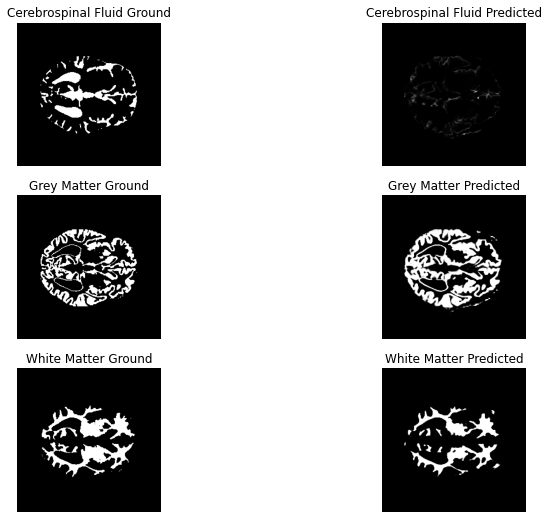

In [89]:
test_x, test_y_ground = next(iter(data_dict['validate'].batch(1)))

test_y_ground = tf.reshape(test_y_ground, [256, 256, 4])

test_y_predict = model.predict(test_x)
test_y_predict = tf.reshape(test_y_predict, [256, 256, 4])

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 9))
labels = ['Cerebrospinal Fluid ', 'Grey Matter ', 'White Matter ']

for i in range(3):
    ax[i][0].imshow(test_y_ground[:, :, i+1], cmap='gray')
    ax[i][0].axis('off')
    ax[i][0].set_title(labels[i] + 'Ground')
    
    ax[i][1].imshow(test_y_predict[:, :, i+1], cmap='gray')
    ax[i][1].axis('off')
    ax[i][1].set_title(labels[i] + 'Predicted')
    
plt.show()

In [87]:
class My_Model(tf.keras.Model):
    def __init__(self):
        super(My_Model, self).__init__()
        self.input_1 = tf.keras.layers.InputLayer()
        self.downshift_1 = Downshift(32)
        self.dropout_1 = Dropout(.4)
        self.upshift_1 = Upshift(32)
        self.dropout_2 = Dropout(.4)
        self.output_1 = tf.keras.layers.Conv2D(4, 1, activation='softmax', padding='same')
        
    def call(self, x, training=False):
        x_0 = self.input_1(x)
        x_1 = self.downshift_1(x_0)
        x_2 = self.dropout_1(x_1)
        x_3 = self.upshift_1(x_2, x_0)
        x_4 = self.dropout_2(x_3)
        x_5 = self.output_1(x_4)
        
        return x_3

In [88]:
history = model.fit(data_dict['train'].batch(50), epochs=4,
                    validation_data=data_dict['validate'].batch(50), verbose=1)

Train for 194 steps, validate for 23 steps
Epoch 1/4
194/194 [==============================] - 212s 1s/step - loss: 0.8255 - mean_io_u_25: 0.5870 - val_loss: 0.8169 - val_mean_io_u_25: 0.5067
Epoch 2/4
194/194 [==============================] - 167s 858ms/step - loss: 0.8232 - mean_io_u_25: 0.5925 - val_loss: 0.8159 - val_mean_io_u_25: 0.7978
Epoch 3/4
194/194 [==============================] - 166s 854ms/step - loss: 0.8220 - mean_io_u_25: 0.5951 - val_loss: 0.8151 - val_mean_io_u_25: 0.7982
Epoch 4/4
194/194 [==============================] - 251s 1s/step - loss: 0.8211 - mean_io_u_25: 0.6085 - val_loss: 0.8142 - val_mean_io_u_25: 0.8058


In [ ]:
test_x, test_y_ground = next(iter(data_dict['validate'].batch(1)))

test_y_ground = tf.reshape(test_y_ground, [256, 256, 4])

test_y_predict = model.predict(test_x)
test_y_predict = tf.reshape(test_y_predict, [256, 256, 4])

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 9))
labels = ['Cerebrospinal Fluid ', 'Grey Matter ', 'White Matter ']

for i in range(3):
    ax[i][0].imshow(test_y_ground[:, :, i+1], cmap='gray')
    ax[i][1].imshow(test_y_predict[:, :, i+1], cmap='gray')
    
plt.show()